In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_queries, topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_queries, physics_category_labels, physics_category_colors


In [2]:
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
with open(f"../training_outputs/first_multiclass_training/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


all_df.shape=(747332, 119)
pred_df.shape=(71178, 20)
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 135)


UndefinedVariableError: name 'wc_kine_reco_Enu' is not defined

# 1g and 2g

In [ ]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_38433/4263806371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


In [ ]:
queries = []
for i, signal_category in enumerate(sig_categories):
    queries.append(f"reco_category_argmax_index == {i}")

In [ ]:
presel_merged_df.columns

Index(['run', 'subrun', 'event', 'filetype', 'wc_net_weight',
       'topological_signal_category', 'physics_signal_category',
       'wc_nue_score', 'wc_numu_score', 'wc_nc_delta_score', 'wc_nc_pio_score',
       'wc_numu_cc_flag', 'wc_shw_sp_n_20mev_showers', 'wc_kine_reco_Enu',
       'wc_kine_energy_particle', 'wc_kine_particle_type', 'wc_match_isFC',
       'wc_truth_nuEnergy', 'wc_truth_nuPdg', 'wc_truth_isCC',
       'wc_match_completeness_energy', 'wc_truth_energyInside',
       'wc_truth_vtxInside', 'wc_weight_cv', 'wc_weight_spline',
       'wc_truth_NprimPio', 'wc_truth_NCDelta', 'wc_reco_nuvtxX',
       'wc_reco_nuvtxY', 'wc_reco_nuvtxZ', 'wc_reco_muonMomentum',
       'wc_reco_showerMomentum', 'wc_reco_showervtxX', 'wc_reco_showervtxY',
       'wc_reco_showervtxZ', 'wc_truth_vtxX', 'wc_truth_vtxY', 'wc_truth_vtxZ',
       'wc_truth_corr_nuvtxX', 'wc_truth_corr_nuvtxY', 'wc_truth_corr_nuvtxZ',
       'wc_truth_Ntrack', 'wc_truth_id', 'wc_truth_pdg', 'wc_truth_mother',
     

UndefinedVariableError: name 'normal_overlay' is not defined

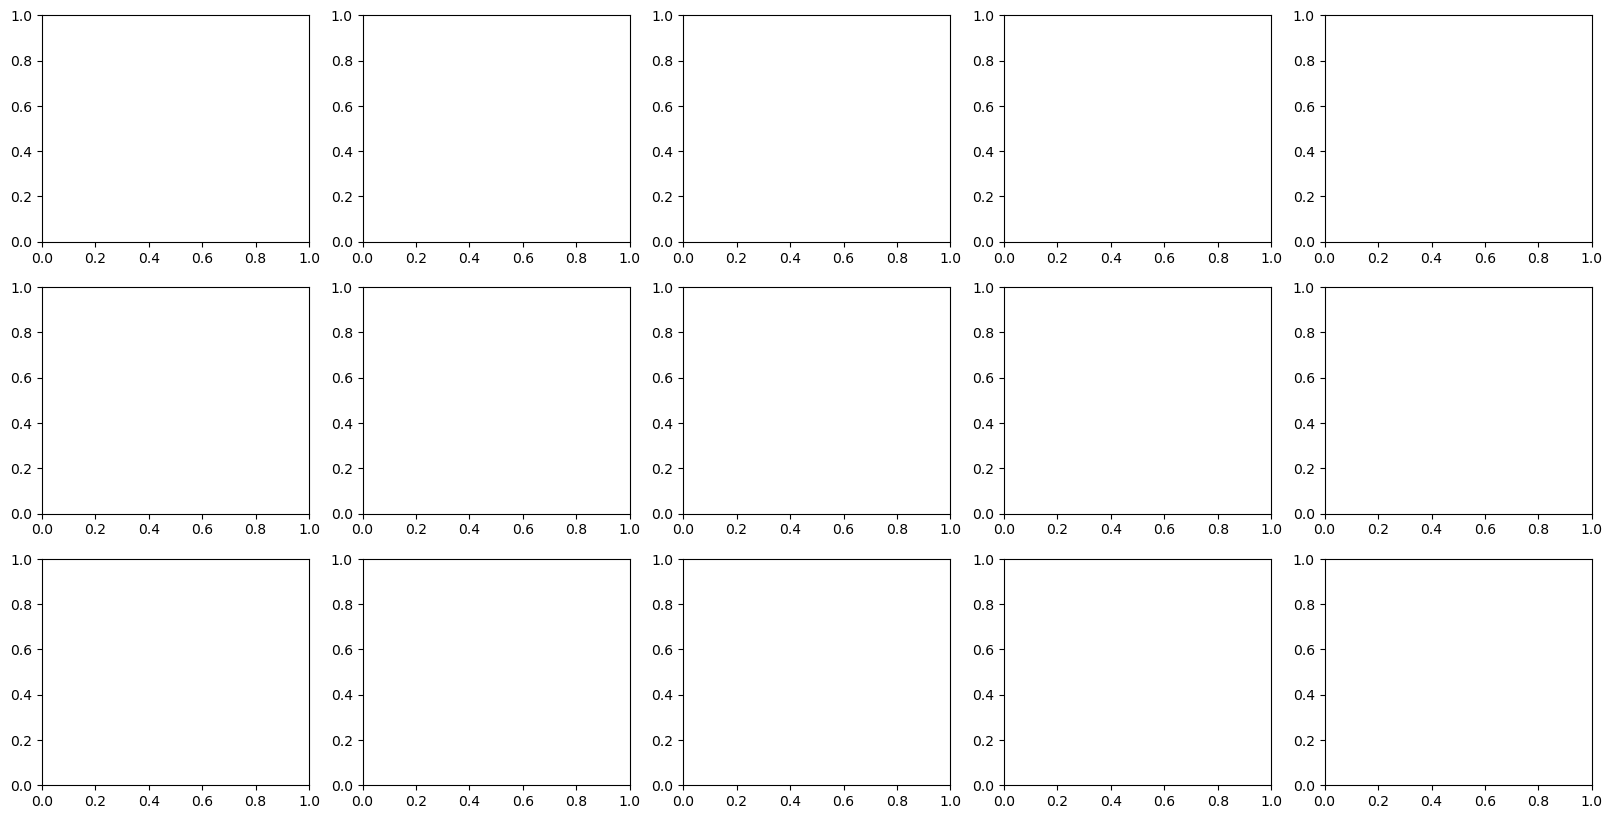

In [ ]:
breakdown_queries = topological_category_queries
breakdown_labels = topological_category_labels
breakdown_colors = topological_category_colors

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs = axs.flatten()

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(topological_category_labels)
outline_colors = ["k"] * len(topological_category_labels)

for i, signal_category in enumerate(sig_categories):

    sel_df = presel_merged_df.query(queries[i])

    counts = []
    for j in range(len(breakdown_labels)):
        curr_df = sel_df.query(breakdown_queries[j])
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
    
    if i >= 10: # Only show x-label for bottom row
        axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if i % 5 == 0: # Only show y-label for leftmost column
        axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
    axs[i].set_title(f"{signal_category} Selection")
    axs[i].set_xlim(0, 2000)
    
    if i == 13:
        axs[i].legend(ncol=2, loc='upper right', bbox_to_anchor=(2.2, 0.7))

axs[14].remove()

fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()
